In [2]:
!pip install pandas_datareader

# OBJECTIVES :

- DATA COLLECTION

    
- PREPROCESS THE TRAIN AND THE TEST DATA


- CREATING AN STACKED LSTM


- PREDICT THE TEST  AND PLOT THE OUTPUT


- PREDICT THE FUTURE 30 DAYS AND PLOT THE OUTPUT

In [7]:
### Data Collection
import pandas_datareader as pdr
key="4b5bbd39da2d6ca51ad864e0e94444a2d9fe78ff"

In [9]:
df = pdr.get_data_tiingo('AAPL', api_key=key)
df.to_csv('AAPL.csv')

In [1]:
import pandas as pd
df=pd.read_csv('AAPL.csv')

In [2]:
df.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [3]:
df.tail()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1253,1253,AAPL,2020-05-18 00:00:00+00:00,314.96,316.50,310.3241,313.17,33843125,314.96,316.50,310.3241,313.17,33843125,0.0,1.0
1254,1254,AAPL,2020-05-19 00:00:00+00:00,313.14,318.52,313.0100,315.03,25432385,313.14,318.52,313.0100,315.03,25432385,0.0,1.0
1255,1255,AAPL,2020-05-20 00:00:00+00:00,319.23,319.52,316.2000,316.68,27876215,319.23,319.52,316.2000,316.68,27876215,0.0,1.0
1256,1256,AAPL,2020-05-21 00:00:00+00:00,316.85,320.89,315.8700,318.66,25672211,316.85,320.89,315.8700,318.66,25672211,0.0,1.0
1257,1257,AAPL,2020-05-22 00:00:00+00:00,318.89,319.23,315.3500,315.77,20450754,318.89,319.23,315.3500,315.77,20450754,0.0,1.0


In [4]:
df1=df.reset_index()['close']

In [5]:
df1.shape

(1258,)

In [6]:
df1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

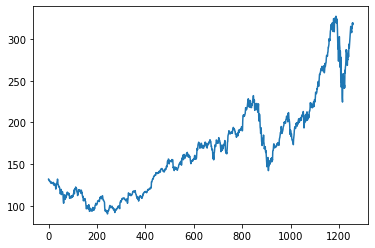

In [7]:
import matplotlib.pyplot as plt
plt.plot(df1)
#There is a huge drop in the stock of apple

In [8]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
import numpy as np
df1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

In [9]:
# Applying the min and max scaler
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [10]:
df1[0:3]# now the data  is converted into 0 to 1 as we used min max scaler

array([[0.17607447],
       [0.17495567],
       [0.16862282]])

In [11]:
#Here we are taking the 65 percentage of the whole data in training size and remaining into the into test data size  

In [12]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [13]:
training_size,test_size

(817, 441)

In [14]:
train_data[0:3]

array([[0.17607447],
       [0.17495567],
       [0.16862282]])

In [15]:
#Now as we know the stocks fluctuate day by day so we have to ensure the prediction remains accurate as possible
#For example we take the day 1 and day 2 stock  and day 3 should  result in day 4 stock 
#Hence here day 1 ,day 2, day 3 are features  and day 4 reamins the target variable.
# THE same happens in the train data and the test data

In [16]:
#Example :
#120,130,125,140,134,150, 160,190,154,160,170
#Train_data - 120,130,125,140,134,150, Test_data-160,190,154,160,170
#Time step = 3                        
#X_train,y_train                   y_train       y_test
#f1  f2  f3  o/p                   160 190 154   160
#120 130 125 140                   190 154 160   170
#130 125 140 134
#125 149 134 150

In [17]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [18]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [19]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [20]:
print(X_test.shape), print(ytest.shape)

(340, 100)
(340,)


(None, None)

In [21]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [22]:
## Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 3s 222ms/step - loss: 0.0208 - val_loss: 0.0630
Epoch 2/100
12/12 [==============================] - 2s 172ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 3/100
12/12 [==============================] - 2s 189ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 4/100
12/12 [==============================] - 2s 186ms/step - loss: 8.3343e-04 - val_loss: 0.0042
Epoch 5/100
12/12 [==============================] - 2s 188ms/step - loss: 6.5905e-04 - val_loss: 0.0044
Epoch 6/100
12/12 [==============================] - 2s 186ms/step - loss: 6.5523e-04 - val_loss: 0.0041
Epoch 7/100
12/12 [==============================] - 2s 186ms/step - loss: 6.2383e-04 - val_loss: 0.0039
Epoch 8/100
12/12 [==============================] - 2s 185ms/step - loss: 6.1736e-04 - val_loss: 0.0039
Epoch 9/100
12/12 [==============================] - 2s 185ms/step - loss: 6.1974e-04 - val_loss: 0.0039
Epoch 10/100
12/12 [==============================] - 2s 186ms/step

12/12 [==============================] - 2s 171ms/step - loss: 1.6253e-04 - val_loss: 9.3347e-04
Epoch 79/100
12/12 [==============================] - 2s 165ms/step - loss: 1.5365e-04 - val_loss: 8.6641e-04
Epoch 80/100
12/12 [==============================] - 2s 153ms/step - loss: 1.5099e-04 - val_loss: 8.5211e-04
Epoch 81/100
12/12 [==============================] - 2s 146ms/step - loss: 1.4363e-04 - val_loss: 0.0011
Epoch 82/100
12/12 [==============================] - 2s 143ms/step - loss: 1.6115e-04 - val_loss: 7.8825e-04
Epoch 83/100
12/12 [==============================] - 2s 141ms/step - loss: 1.6044e-04 - val_loss: 0.0011
Epoch 84/100
12/12 [==============================] - 2s 144ms/step - loss: 1.5362e-04 - val_loss: 0.0019
Epoch 85/100
12/12 [==============================] - 2s 142ms/step - loss: 2.3336e-04 - val_loss: 0.0010
Epoch 86/100
12/12 [==============================] - 2s 141ms/step - loss: 1.7185e-04 - val_loss: 9.8526e-04
Epoch 87/100
12/12 [===================

In [24]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [25]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [26]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

142.86418226892687

In [27]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

240.76016665112618

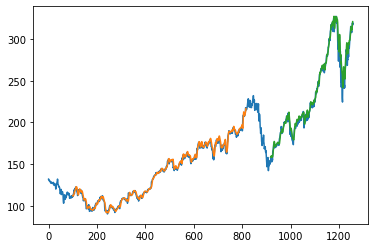

In [28]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [29]:
len(test_data)

441

In [30]:
441-100

341

In [31]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape


(1, 100)

In [32]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input[0:3]

[0.8583551465000423, 0.8866418981676942, 0.8743139407244789]

In [33]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.9746863]
101
1 day input [0.8866419  0.87431394 0.88431985 0.87836697 0.8986321  0.92582116
 0.92877649 0.95676771 0.93869797 0.93304061 0.94950604 0.96424048
 0.95512117 0.95989192 0.96635143 0.96246728 0.92295027 0.9598497
 0.98792536 0.98594106 0.92531453 0.92172591 0.96474711 0.97572406
 0.99159841 0.96972895 0.97614625 0.96795575 1.         0.99016297
 0.99050072 0.96538039 0.98488559 0.97086887 0.94026007 0.87748037
 0.83483915 0.85413324 0.77336823 0.77269273 0.88014017 0.84007431
 0.89673225 0.85527316 0.83884995 0.74233725 0.82327113 0.78143207
 0.6665963  0.7921557  0.64118044 0.68614371 0.66001013 0.65203074
 0.58642236 0.56586169 0.66089673 0.65515494 0.70970193 0.66452757
 0.69437642 0.69218104 0.63569197 0.65266402 0.63780292 0.7267162
 0.71388162 0.74191506 0.75002111 0.77222832 0.83049059 0.8194292
 0.8289707  0.8125475  0.78776492 0.75162543 0.78426074 0.77974331
 0.81326522 0.8141096  0.79473106 0.83336148 0.85898843 0.83901883
 0.85628641 0.87486279 0.88782403 0.9

10 day output [[1.0159886]]
11 day input [0.94950604 0.96424048 0.95512117 0.95989192 0.96635143 0.96246728
 0.92295027 0.9598497  0.98792536 0.98594106 0.92531453 0.92172591
 0.96474711 0.97572406 0.99159841 0.96972895 0.97614625 0.96795575
 1.         0.99016297 0.99050072 0.96538039 0.98488559 0.97086887
 0.94026007 0.87748037 0.83483915 0.85413324 0.77336823 0.77269273
 0.88014017 0.84007431 0.89673225 0.85527316 0.83884995 0.74233725
 0.82327113 0.78143207 0.6665963  0.7921557  0.64118044 0.68614371
 0.66001013 0.65203074 0.58642236 0.56586169 0.66089673 0.65515494
 0.70970193 0.66452757 0.69437642 0.69218104 0.63569197 0.65266402
 0.63780292 0.7267162  0.71388162 0.74191506 0.75002111 0.77222832
 0.83049059 0.8194292  0.8289707  0.8125475  0.78776492 0.75162543
 0.78426074 0.77974331 0.81326522 0.8141096  0.79473106 0.83336148
 0.85898843 0.83901883 0.85628641 0.87486279 0.88782403 0.90095415
 0.92793211 0.948535   0.93333615 0.91746179 0.92544119 0.91771511
 0.9483239  0.9406400

20 day output [[1.048637]]
21 day input [0.92531453 0.92172591 0.96474711 0.97572406 0.99159841 0.96972895
 0.97614625 0.96795575 1.         0.99016297 0.99050072 0.96538039
 0.98488559 0.97086887 0.94026007 0.87748037 0.83483915 0.85413324
 0.77336823 0.77269273 0.88014017 0.84007431 0.89673225 0.85527316
 0.83884995 0.74233725 0.82327113 0.78143207 0.6665963  0.7921557
 0.64118044 0.68614371 0.66001013 0.65203074 0.58642236 0.56586169
 0.66089673 0.65515494 0.70970193 0.66452757 0.69437642 0.69218104
 0.63569197 0.65266402 0.63780292 0.7267162  0.71388162 0.74191506
 0.75002111 0.77222832 0.83049059 0.8194292  0.8289707  0.8125475
 0.78776492 0.75162543 0.78426074 0.77974331 0.81326522 0.8141096
 0.79473106 0.83336148 0.85898843 0.83901883 0.85628641 0.87486279
 0.88782403 0.90095415 0.92793211 0.948535   0.93333615 0.91746179
 0.92544119 0.91771511 0.9483239  0.94064004 0.96635143 0.9563033
 0.96491598 0.97468632 0.97957689 0.98586482 0.99144566 0.99598229
 0.99975204 1.00308192 1.0

In [34]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [35]:
import matplotlib.pyplot as plt
len(df1)

1258

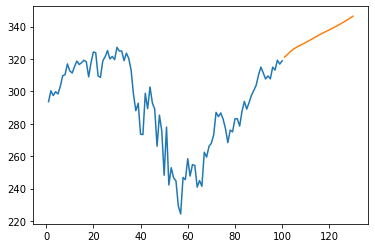

In [36]:
plt.plot(day_new,scaler.inverse_transform(df1[1158:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

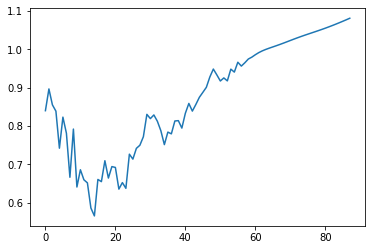

In [37]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [38]:

df3=scaler.inverse_transform(df3).tolist()

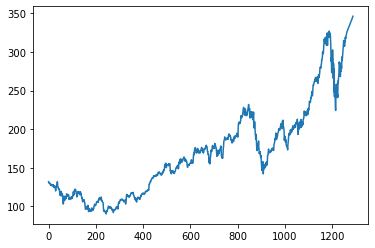

In [39]:
plt.plot(df3)